In [1]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching
from imp import reload
reload(alpenglow.stitching)
reload(alpenglow.files)
from alpenglow.stitching import stitch, find_shift, apply_shift

In [2]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage.external.tifffile as tif
import skimage
import dask.array as da
from dask import delayed

In [5]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('alpenglowoptics')
ll = list(bucket.objects.all())

In [6]:
import numpy as np
import os
import boto3


def download_s3(remote_fname, local_fname, bucket_name="alpenglowoptics"):
    """
    Download a file from S3 to our local file-system
    """
    if not os.path.exists(local_fname):
        s3 = boto3.resource('s3')
        b = s3.Bucket(bucket_name)
        b.download_file(remote_fname, local_fname)  

In [7]:
for x in range(4, 32):
        fname = "im_%06d_000055.tif" % x 
        download_s3('76AO/Strips/' + fname, '../data/AO/' + fname)    


In [3]:
image1 = tif.imread('../data/AO/im_000005_000055.tif')
image2 = tif.imread('../data/AO/im_000006_000055.tif')
mosaic, shift = stitch(image1, image2) #stitching 5 with 6 to produce mosaic

../alpenglow/stitching.py:71: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
../alpenglow/stitching.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered[rows2-margin:, abs(shift[1]):] = image1[overlap-margin:, :shift[1]]
../alpenglow/stitching.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fade1[:, abs(shift[1]):] = image1[overlap-margin:overlap, :shift[1]] * np.arange(0, 1, 0.01)[:, np.newaxis]


In [4]:
for x in range (7, 32):
    image2 = tif.imread('../data/AO/im_%06d_000055.tif' % x)
    mosaic, shift = stitch(mosaic, image2)

../alpenglow/stitching.py:71: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
../alpenglow/stitching.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered[rows2-margin:, :cols1-shift[1]] = image1[overlap-margin:, shift[1]:]
../alpenglow/stitching.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fade1[:, :cols1-shift[1]] = image1[overlap-margin:overlap, shift[1]:] * np.arange(0, 1, 0.01)[:, np.newaxis]
../alpenglow/stitching.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered[rows2-margin:, abs(shift[1]):] = image1[overlap-margin:, :shift[1]]
../alpenglow/stitching.py:84: VisibleDeprecationWarning: using a non-integer numb

In [6]:
mosaic.dtype

dtype('int64')

In [5]:
mosaic = mosaic.astype('int16')

In [8]:
mosaic.dtype

dtype('int16')

In [9]:
mosaic.shape

(14926, 23872)

In [16]:
tif.imsave('../data/AO/mosaic_000055_raw.tif', mosaic)

In [17]:
# Upload /tmp/myfile to s3://bucket/key
from boto3.s3.transfer import S3Transfer
client = boto3.client('s3', 'us-west-2')
transfer = S3Transfer(client)
transfer.upload_file('../data/AO/mosaic_000055_raw.tif', 'alpenglowoptics', '76AO_mosaic_raw')

In [6]:
mosaic_adapteq = exposure.equalize_adapthist(mosaic, clip_limit=0.01)

/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from int16 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [ ]:
plt.matshow(mosaic_adapteq[10000:15000, 10000:20000])

In [11]:
mosaic_adapteq.dtype

dtype('float64')

In [7]:
mosaic_adapteq = img_as_int(mosaic_adapteq)

/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to int16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [15]:
mosaic_adapteq.dtype

dtype('int16')

In [16]:
tif.imsave('../data/AO/mosaic_000055_raw_adapteq.tif', mosaic_adapteq)

In [17]:
# Upload /tmp/myfile to s3://bucket/key
from boto3.s3.transfer import S3Transfer
client = boto3.client('s3', 'us-west-2')
transfer = S3Transfer(client)
transfer.upload_file('../data/AO/mosaic_000055_raw_adapteq.tif', 'alpenglowoptics', '76AO_mosaic_raw_adapteq')

### Seeing if I can do the FFT

In [8]:
f = np.fft.fft2(mosaic_adapteq[10000:15000, 10000:15000])

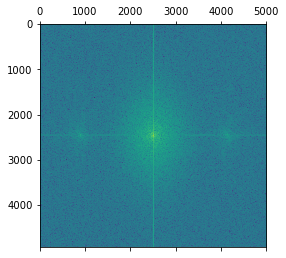

In [9]:
plt.matshow(np.log(np.fft.fftshift(np.abs(f))))

In [12]:
f_shift = np.fft.fftshift(f)

In [13]:
f_shift[2500-100:2500+10, 600:1000] = np.mean(f_shift)
f_shift[2500-100:2500+10, -1000:-600] = np.mean(f_shift)

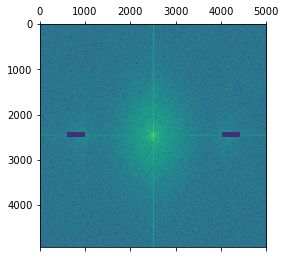

In [14]:
plt.matshow(np.log(np.abs(f_shift)))

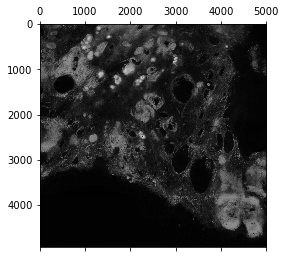

In [15]:
plt.matshow(np.abs(np.fft.ifft2(np.fft.fftshift(f_shift))), cmap='gray')